In [1]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import scipy
import utils_dagma
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score
from copy import deepcopy
import fdr_control

In [2]:
def fdr_log(Z, W_true, n_jobs):
    W_true = true_data['W_true']
    
    from joblib import Parallel, delayed
    from tqdm import tqdm
    from copy import deepcopy
    fdr=0.2
    num_feat = 100
    est_type = 'tau+'
    n_jobs = 1
    
    print(f"==============================")
    print(f"expected FDR {fdr}")
    
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
    
    T_T_true = np.abs(W_true)
    mask = (T_T_true > 0.)
    T_T_true[mask], T_T_true[~mask] = 1, 0
    
    fdr_est_last = 1.
    t_last = np.inf
    
    def _get_t(t_list: list):
        t_last = np.inf
        fdr_est_last = None
        for t in reversed(t_list):
            if t < 0.:
                break
            if est_type == 'tau':
                fdr_est = ((Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            else:
                fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            
            T_T = Z.copy()
            mask = (T_T >= t)
            T_T[mask], T_T[~mask] = 1, 0
            perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
            fdr_true, power = perf['fdr'], perf['tpr']
            print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    
            if fdr_est <= fdr:
                t_last = t
                fdr_est_last = fdr_est
        return t_last, fdr_est_last
        
    interval = len(t_list) // n_jobs
    intervals = [(j * interval, (j+1) * interval) for j in range(n_jobs - 1)]
    intervals.append(
        ((n_jobs-1) * interval, len(t_list))
    )
    res1 = []
    res1 = Parallel(n_jobs=n_jobs)(
            delayed(_get_t)(
                t_list[interval[0]:interval[1]]
            ) for interval in intervals
        )
    
    
    res = np.array([list(_res) for _res in res1 if not np.isinf(_res[0]) and _res[1] is not None])
    if len(res) > 0: # otherwise, no edge being selected
        t_last = res[:, 0].min()
        t_last_idx = np.argmin(res[:, 0])
        fdr_est_last = res[t_last_idx, 1]
    
    mask = (Z >= t_last)
    Z[mask], Z[~mask] = 1, 0
    T_T = Z
    
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']
    
    if utils_dagma.is_dag(T_T):
        print("W_est is DAG")
    else:
        print("W_est is NOT DAG")
    print(f"expected fdr {fdr:.1f} | sel thresh {t_last:.4e} | "
          f"est fdr {fdr_est_last:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    print(f"==============================")

In [3]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v11/v100_600_normX_sym1/'
with open(path + f'X/X_1.pkl', 'rb') as f:
    true_data = pickle.load(f)
X = true_data['X']
W_true = true_data['W_true']
B_true = (W_true != 0)

In [4]:
rng = np.random.default_rng(0)

# dag_8, option 1

In [27]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W = pickle.load(f)['W_est']
Z = np.abs(W[:100, :100]) - np.abs(W[100:, :100])

In [28]:
_Z = deepcopy(Z)

In [29]:
d=100
selectors = rng.binomial(1, 0.5, [d, d])
cnt=0
for i in range(d):
    for j in range(i, d):
        if _Z[i, j] > _Z[j, i]:
            _Z[j, i] = 0.
            cnt+=1
        elif _Z[i, j] < _Z[j, i]:
            _Z[i, j] = 0.
            cnt+=1
        else:
            if selectors[i, j] == 1:
                _Z[j, i] = 0.
            else:
                _Z[i, j] = 0.

Text(0.5, 1.0, '100 * 600 | Z distribution | PLS, all other nodes fit j | option 1 on Z')

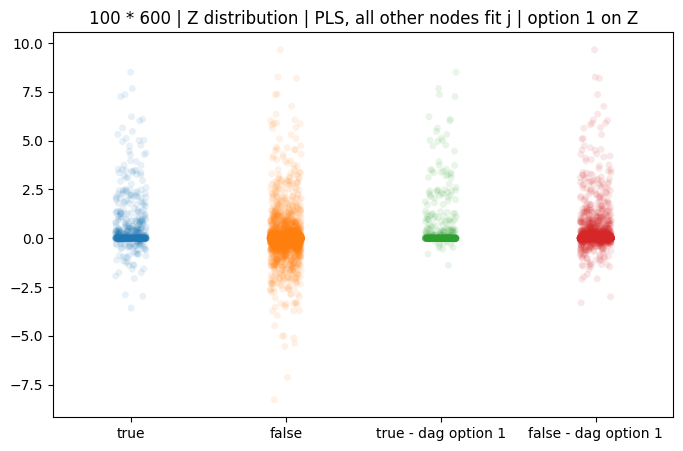

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
data = {
    'true': Z[B_true].flatten(), 
    'false': Z[~B_true].flatten(), 
    'true - dag option 1': _Z[B_true].flatten(),
    'false - dag option 1': _Z[~B_true].flatten(),
}
sns.stripplot(data, alpha=0.1, ax=ax)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j | option 1 on Z")

# dag_9, option 1 on |W|

In [32]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])

In [33]:
W = np.abs(W_full[:d, :d])
selectors = np.random.binomial(1, 0.5, [d, d])
cnt = 0
for i in range(d):
    for j in range(i, d):
        if W[i, j] > W[j, i]:
            W_full[j, i] = 0.
            W_full[j+d, i] = 0.
            cnt += 1
        elif W[i, j] < W[j, i]:
            W_full[i, j] = 0.
            W_full[i+d, j] = 0.
            cnt += 1
        else:
            if selectors[i, j] == 1:
                W_full[j, i] = 0.
                W_full[j+d, i] = 0.
            else:
                W_full[i, j] = 0.
                W_full[i+d, j] = 0.
W = W_full[:, :d]

In [34]:
_Z = np.abs(W[:100, :100]) - np.abs(W[100:, :100])

Text(0.5, 1.0, '100 * 600 | Z distribution | PLS, all other nodes fit j | option 1 on |W|')

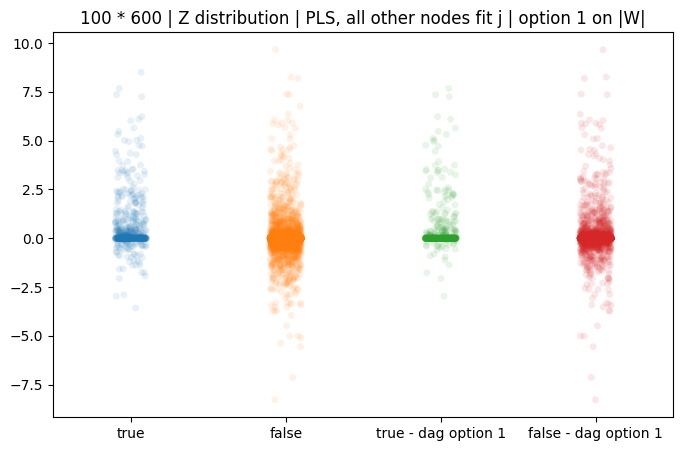

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
data = {
    'true': Z[B_true].flatten(), 
    'false': Z[~B_true].flatten(), 
    'true - dag option 1': _Z[B_true].flatten(),
    'false - dag option 1': _Z[~B_true].flatten(),
}
sns.stripplot(data, alpha=0.1, ax=ax)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j | option 1 on |W|")

# dag_10_0, option 2

In [12]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_ori = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])


mask = fdr_control.extract_dag_mask(Z_ori, 4)
Z = Z_ori.copy()
_Z = Z.copy()
Z[~mask] = 0.
assert (_Z[_Z < 0.] == Z[Z < 0.]).all()

In [13]:
fdr_log(Z.copy(), W_true, 1)

expected FDR 0.2
thresh 9.6508 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 8.5015 | est fdr 0.5000 | true fdr 0.5000 | true power 0.0017
thresh 8.2700 | est fdr 1.0000 | true fdr 0.5000 | true power 0.0017
thresh 8.2531 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0017
thresh 8.1862 | est fdr 0.5000 | true fdr 0.7500 | true power 0.0017
thresh 7.6681 | est fdr 0.4000 | true fdr 0.6000 | true power 0.0033
thresh 7.3544 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0033
thresh 7.3533 | est fdr 0.2857 | true fdr 0.5714 | true power 0.0050
thresh 7.2503 | est fdr 0.2500 | true fdr 0.5000 | true power 0.0067
thresh 7.1287 | est fdr 0.3750 | true fdr 0.5000 | true power 0.0067
thresh 6.7561 | est fdr 0.3333 | true fdr 0.5556 | true power 0.0067
thresh 6.3543 | est fdr 0.3000 | true fdr 0.6000 | true power 0.0067
thresh 6.2227 | est fdr 0.2727 | true fdr 0.5455 | true power 0.0083
thresh 6.0938 | est fdr 0.2500 | true fdr 0.5000 | true power 0.0100
thresh 6.0626 | e

In [17]:
(Z > 0.).sum()

1181

In [18]:
(Z_ori > 0.).sum()

1848

Text(0.5, 1.0, '100 * 600 | Z distribution | PLS, all other nodes fit j | option 2')

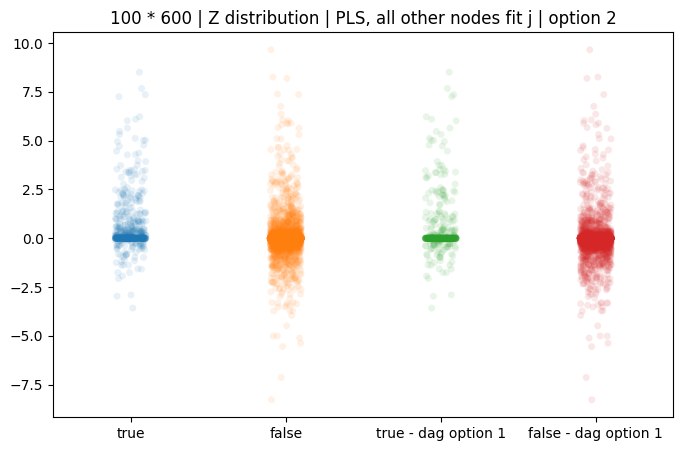

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
data = {
    'true': Z_ori[B_true].flatten(), 
    'false': Z_ori[~B_true].flatten(), 
    'true - dag option 1': Z[B_true].flatten(),
    'false - dag option 1': Z[~B_true].flatten(),
}
sns.stripplot(data, alpha=0.1, ax=ax)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j | option 2")

# dag_10_Z_min, option 2 on |W|

In [36]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_ori = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])


mask = fdr_control.extract_dag_mask(Z_ori, 4)
Z_ori_min = Z_ori.min()
Z = Z_ori.copy()
Z[~mask] = Z_ori_min

In [37]:
fdr_log(Z.copy(), W_true, 1)

expected FDR 0.2
thresh 9.6508 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 8.5015 | est fdr 0.5000 | true fdr 0.5000 | true power 0.0017
thresh 8.2700 | est fdr 334.5000 | true fdr 0.5000 | true power 0.0017
thresh 8.2531 | est fdr 223.0000 | true fdr 0.6667 | true power 0.0017
thresh 8.1862 | est fdr 167.2500 | true fdr 0.7500 | true power 0.0017
thresh 7.6681 | est fdr 133.8000 | true fdr 0.6000 | true power 0.0033
thresh 7.3544 | est fdr 111.5000 | true fdr 0.6667 | true power 0.0033
thresh 7.3533 | est fdr 95.5714 | true fdr 0.5714 | true power 0.0050
thresh 7.2503 | est fdr 83.6250 | true fdr 0.5000 | true power 0.0067
thresh 7.1287 | est fdr 83.7500 | true fdr 0.5000 | true power 0.0067
thresh 6.7561 | est fdr 74.4444 | true fdr 0.5556 | true power 0.0067
thresh 6.3543 | est fdr 67.0000 | true fdr 0.6000 | true power 0.0067
thresh 6.2227 | est fdr 60.9091 | true fdr 0.5455 | true power 0.0083
thresh 6.0938 | est fdr 55.8333 | true fdr 0.5000 | true power 0.0100


In [38]:
(Z > 0.).sum()

1181

In [39]:
(Z_ori > 0.).sum()

1848

In [43]:
(Z_ori[~B_true] > 0.).sum()

1546

In [42]:
(Z[~B_true] > 0.).sum()

1039

In [44]:
(Z_ori[B_true] > 0.).sum()

302

In [45]:
(Z[B_true] > 0.).sum()

142

Text(0.5, 1.0, '100 * 600 | Z distribution | PLS, all other nodes fit j | option 2 | shift to Z_min')

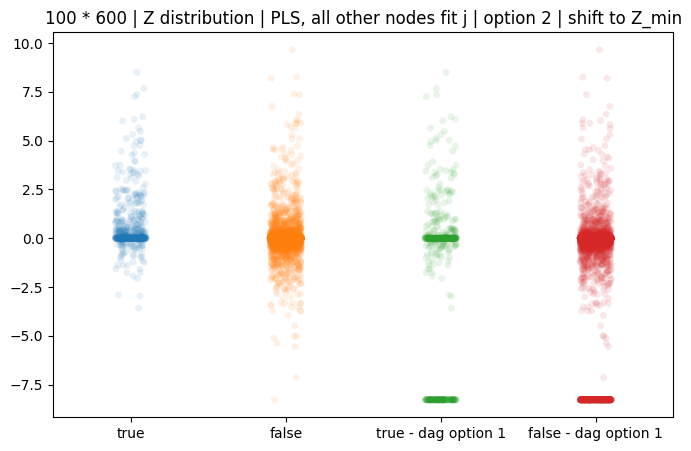

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
data = {
    'true': Z_ori[B_true].flatten(), 
    'false': Z_ori[~B_true].flatten(), 
    'true - dag option 1': Z[B_true].flatten(),
    'false - dag option 1': Z[~B_true].flatten(),
}
sns.stripplot(data, alpha=0.1, ax=ax)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j | option 2 | shift to Z_min")

# dag_13, option 3

In [5]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_ori = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])


W = np.abs(W_full[:d, :d])
mask = fdr_control.extract_dag_mask(W, 5)
mask = np.concatenate([mask, mask], axis=0)
W = W_full[:, :d]
W[~mask] = 0.
Z = W[:100] - W[100:]

Text(0.5, 1.0, '100 * 600 | Z distribution | PLS, all other nodes fit j | option 3')

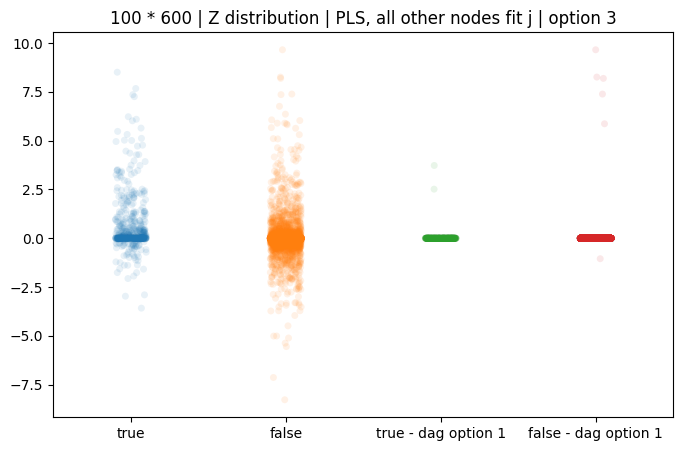

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
data = {
    'true': Z_ori[B_true].flatten(), 
    'false': Z_ori[~B_true].flatten(), 
    'true - dag option 1': Z[B_true].flatten(),
    'false - dag option 1': Z[~B_true].flatten(),
}
sns.stripplot(data, alpha=0.1, ax=ax)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j | option 3")

# try average over W and see if things getting better

In [190]:
W_full_list = []
Z_full_list = []
for seedW in range(0, 10):
    path = f'/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/W/W_1_1_{seedW}.pkl'
    with open(path, 'rb') as f:
        W_full = pickle.load(f)['W_est']
    W_full_list.append(W_full)
    Z = W_full[:100, :100] - W_full[100:, :100]
    Z_full_list.append(Z)
W_full = np.stack(W_full_list).mean(axis=0)
Z = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])
Z_full = np.stack(Z_full_list)

0: 9.650832647946768
1: 8.070062383531221
2: 1.8880783985637541
3: 6.092207651868891
4: 2.527102732689432
5: 8.326191121728131
6: 4.827867940360655
7: 3.511218126946866
8: 5.409897294950589
9: 6.17837136719868


Text(0, 0.5, 'knockoff statistics')

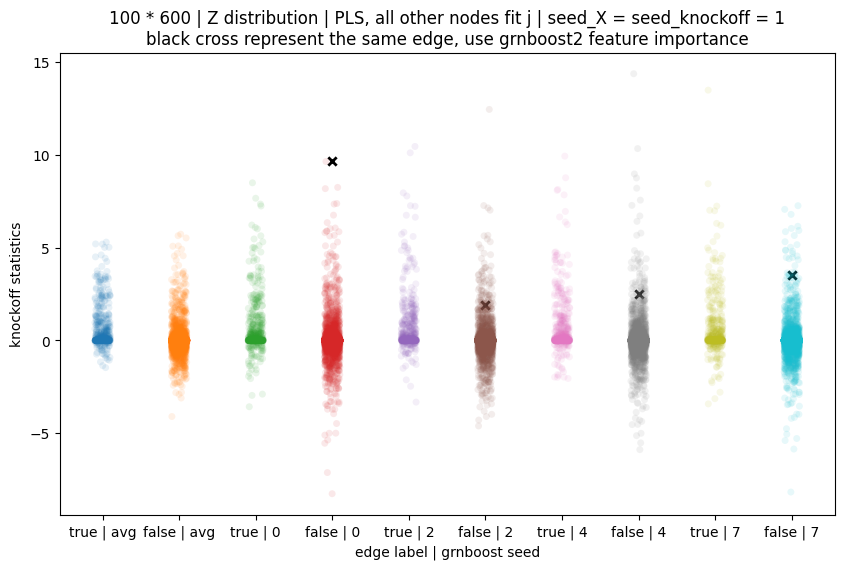

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
data = {
    'true | avg': Z[B_true].flatten(), 
    'false | avg': Z[~B_true].flatten(), 

    'true | 0': Z_full[0][B_true].flatten(), 
    'false | 0': Z_full[0][~B_true].flatten(), 

    'true | 2': Z_full[2][B_true].flatten(), 
    'false | 2': Z_full[2][~B_true].flatten(), 

    'true | 4': Z_full[4][B_true].flatten(), 
    'false | 4': Z_full[4][~B_true].flatten(), 

    'true | 7': Z_full[7][B_true].flatten(), 
    'false | 7': Z_full[7][~B_true].flatten(), 
}
sns.stripplot(data, alpha=0.1, ax=ax)

for i in range(len(Z_full)):
    print(f"{i}:", Z_full[i][61, 25])

data_highlight = {
    'false | 0': Z_full[0][61, 25],
    'false | 2': Z_full[2][61, 25],
    'false | 4': Z_full[4][61, 25],
    'false | 7': Z_full[7][61, 25],
}
sns.scatterplot(data_highlight, ax=ax, marker='x', color='black', linewidths=2)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j | seed_X = seed_knockoff = 1\n"
             "black cross represent the same edge, use grnboost2 feature importance")
ax.set_xlabel("edge label | grnboost seed")
ax.set_ylabel("knockoff statistics")

In [179]:
fdr_log(Z, W_true, 1)

expected FDR 0.2
thresh 5.7301 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 5.6482 | est fdr 0.5000 | true fdr 1.0000 | true power 0.0000
thresh 5.5266 | est fdr 0.3333 | true fdr 1.0000 | true power 0.0000
thresh 5.3017 | est fdr 0.2500 | true fdr 0.7500 | true power 0.0017
thresh 5.2040 | est fdr 0.2000 | true fdr 0.6000 | true power 0.0033
thresh 5.1935 | est fdr 0.1667 | true fdr 0.5000 | true power 0.0050
thresh 5.0968 | est fdr 0.1429 | true fdr 0.5714 | true power 0.0050
thresh 5.0816 | est fdr 0.1250 | true fdr 0.6250 | true power 0.0050
thresh 5.0218 | est fdr 0.1111 | true fdr 0.5556 | true power 0.0067
thresh 5.0158 | est fdr 0.1000 | true fdr 0.5000 | true power 0.0083
thresh 4.9181 | est fdr 0.0909 | true fdr 0.5455 | true power 0.0083
thresh 4.6917 | est fdr 0.0833 | true fdr 0.5833 | true power 0.0083
thresh 4.6104 | est fdr 0.0769 | true fdr 0.5385 | true power 0.0100
thresh 4.5641 | est fdr 0.0714 | true fdr 0.5714 | true power 0.0100
thresh 4.5531 | e

# try elasticNet which should mitigates unstable coef problem (collinearity), see Z distribution, OLS cuda knockoff
* wrong exp: this is OLS_cuda rather than PLS

In [148]:
# baseline: OLS
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=0_l1_ratio=0.1/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_ori = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])

In [149]:
Z_list = []
# try 1: L1+L2, alpha=1, l1_ratil=0.1, l2_ratio=0.9
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=1_l1_ratio=0.1/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 2: L1+L2, alpha=1, l1_ratil=0.5, l2_ratio=0.5
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=1_l1_ratio=0.5/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))


# try 3: L1+L2, alpha=1, l1_ratil=0.9, l2_ratio=0.1
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=1_l1_ratio=0.9/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 4: L1+L2, alpha=0.1, l1_ratil=0.1, l2_ratio=0.9
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=0.1_l1_ratio=0.1/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 5: L1+L2, alpha=0.1, l1_ratil=0.5, l2_ratio=0.5
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=0.1_l1_ratio=0.5/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))


# try 6: L1+L2, alpha=0.1, l1_ratil=0.9, l2_ratio=0.1
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=0.1_l1_ratio=0.9/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 7: L1+L2, alpha=0.01, l1_ratil=0.1, l2_ratio=0.9
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=0.01_l1_ratio=0.1/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 8: L1+L2, alpha=0.01, l1_ratil=0.5, l2_ratio=0.5
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=0.01_l1_ratio=0.5/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))


# try 9: L1+L2, alpha=0.01, l1_ratil=0.9, l2_ratio=0.1
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=OLS_cuda_model=L1+L2_alpha=0.01_l1_ratio=0.9/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

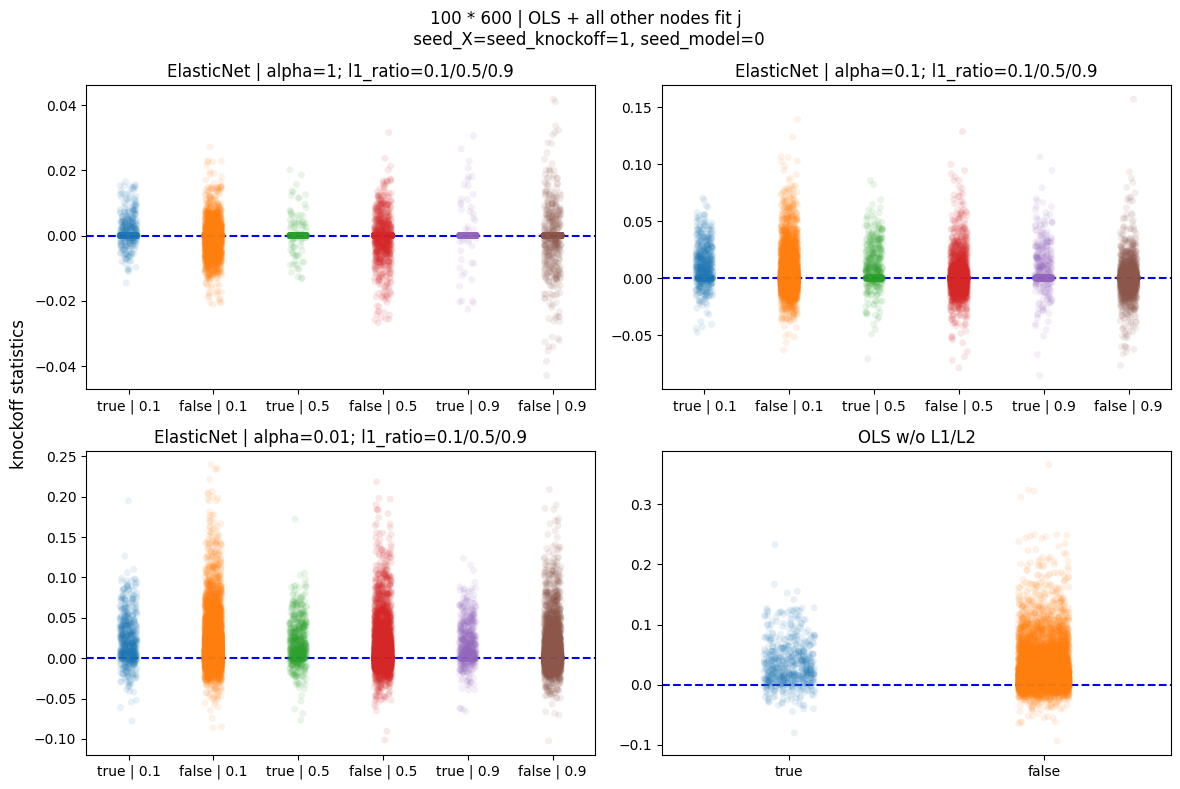

In [150]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

ax = axs[0][0]
data = {}
for i, Z in enumerate(Z_list[0:3]):
    if i % 3 == 0:
        suffix = '0.1'
    elif i % 3 == 1:
        suffix = '0.5'
    elif i % 3 == 2:
        suffix = '0.9'
    data[f'true | {suffix}'] = Z[B_true].flatten()
    data[f'false | {suffix}'] = Z[~B_true].flatten()
    
sns.stripplot(data, alpha=0.1, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
ax.set_title("ElasticNet | alpha=1; l1_ratio=0.1/0.5/0.9")

ax = axs[0][1]
data = {}
for i, Z in enumerate(Z_list[3:6]):
    if i % 3 == 0:
        suffix = '0.1'
    elif i % 3 == 1:
        suffix = '0.5'
    elif i % 3 == 2:
        suffix = '0.9'
    data[f'true | {suffix}'] = Z[B_true].flatten()
    data[f'false | {suffix}'] = Z[~B_true].flatten()
    
sns.stripplot(data, alpha=0.1, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
ax.set_title("ElasticNet | alpha=0.1; l1_ratio=0.1/0.5/0.9")

ax = axs[1][0]
data = {}
for i, Z in enumerate(Z_list[6:9]):
    if i % 3 == 0:
        suffix = '0.1'
    elif i % 3 == 1:
        suffix = '0.5'
    elif i % 3 == 2:
        suffix = '0.9'
    data[f'true | {suffix}'] = Z[B_true].flatten()
    data[f'false | {suffix}'] = Z[~B_true].flatten()    
sns.stripplot(data, alpha=0.1, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
ax.set_title("ElasticNet | alpha=0.01; l1_ratio=0.1/0.5/0.9")

ax = axs[1][1]
data = {}

data[f'true'] = Z_ori[B_true].flatten()
data[f'false'] = Z_ori[~B_true].flatten()
    
sns.stripplot(data, alpha=0.1, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
ax.set_title("OLS w/o L1/L2")

fig.suptitle("100 * 600 | OLS + all other nodes fit j\n seed_X=seed_knockoff=1, seed_model=0")
fig.supylabel('knockoff statistics')
fig.tight_layout()

# try elasticNet which should mitigates unstable coef problem (collinearity), see Z distribution, PLS knockoff

In [161]:
# baseline: PLS
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=0_l1_ratio=0.1/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_ori = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])

In [162]:
Z_list = []
# try 1: L1+L2, alpha=1, l1_ratil=0.1, l2_ratio=0.9
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=1_l1_ratio=0.1/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 2: L1+L2, alpha=1, l1_ratil=0.5, l2_ratio=0.5
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=1_l1_ratio=0.5/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))


# try 3: L1+L2, alpha=1, l1_ratil=0.9, l2_ratio=0.1
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=1_l1_ratio=0.9/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 4: L1+L2, alpha=0.1, l1_ratil=0.1, l2_ratio=0.9
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=0.1_l1_ratio=0.1/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 5: L1+L2, alpha=0.1, l1_ratil=0.5, l2_ratio=0.5
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=0.1_l1_ratio=0.5/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))


# try 6: L1+L2, alpha=0.1, l1_ratil=0.9, l2_ratio=0.1
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=0.1_l1_ratio=0.9/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 7: L1+L2, alpha=0.01, l1_ratil=0.1, l2_ratio=0.9
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=0.01_l1_ratio=0.1/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

# try 8: L1+L2, alpha=0.01, l1_ratil=0.5, l2_ratio=0.5
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=0.01_l1_ratio=0.5/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))


# try 9: L1+L2, alpha=0.01, l1_ratil=0.9, l2_ratio=0.1
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX=sym1_option=5_knock=PLS_model=L1+L2_alpha=0.01_l1_ratio=0.9/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_list.append(np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

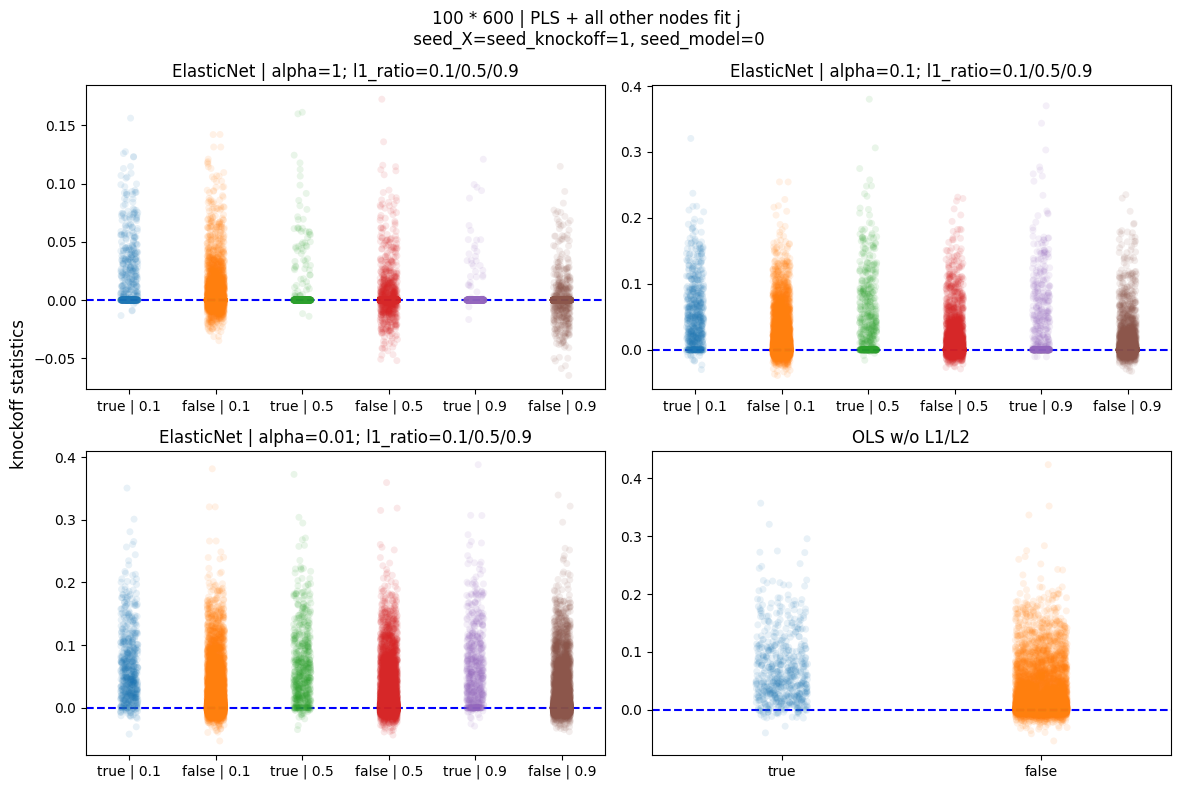

In [163]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

ax = axs[0][0]
data = {}
for i, Z in enumerate(Z_list[0:3]):
    if i % 3 == 0:
        suffix = '0.1'
    elif i % 3 == 1:
        suffix = '0.5'
    elif i % 3 == 2:
        suffix = '0.9'
    data[f'true | {suffix}'] = Z[B_true].flatten()
    data[f'false | {suffix}'] = Z[~B_true].flatten()
    
sns.stripplot(data, alpha=0.1, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
ax.set_title("ElasticNet | alpha=1; l1_ratio=0.1/0.5/0.9")

ax = axs[0][1]
data = {}
for i, Z in enumerate(Z_list[3:6]):
    if i % 3 == 0:
        suffix = '0.1'
    elif i % 3 == 1:
        suffix = '0.5'
    elif i % 3 == 2:
        suffix = '0.9'
    data[f'true | {suffix}'] = Z[B_true].flatten()
    data[f'false | {suffix}'] = Z[~B_true].flatten()
    
sns.stripplot(data, alpha=0.1, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
ax.set_title("ElasticNet | alpha=0.1; l1_ratio=0.1/0.5/0.9")

ax = axs[1][0]
data = {}
for i, Z in enumerate(Z_list[6:9]):
    if i % 3 == 0:
        suffix = '0.1'
    elif i % 3 == 1:
        suffix = '0.5'
    elif i % 3 == 2:
        suffix = '0.9'
    data[f'true | {suffix}'] = Z[B_true].flatten()
    data[f'false | {suffix}'] = Z[~B_true].flatten()    
sns.stripplot(data, alpha=0.1, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
ax.set_title("ElasticNet | alpha=0.01; l1_ratio=0.1/0.5/0.9")

ax = axs[1][1]
data = {}

data[f'true'] = Z_ori[B_true].flatten()
data[f'false'] = Z_ori[~B_true].flatten()
    
sns.stripplot(data, alpha=0.1, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
ax.set_title("OLS w/o L1/L2")

fig.suptitle("100 * 600 | PLS + all other nodes fit j\n seed_X=seed_knockoff=1, seed_model=0")
fig.supylabel('knockoff statistics')
fig.tight_layout()

# try tree-shap which should mitigates unstable coef problem (collinearity), see Z distribution, PLS knockoff, grnboost2

In [324]:
W_full_list = []
Z_full_list = []
for seedW in range(1, 11):
    path = f'/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX=sym1_option=5_knock=PLS_model=grnboost2_imp=shap/W/W_1_1_{seedW}.pkl'
    with open(path, 'rb') as f:
        W_full = pickle.load(f)['W_est']
    W_full_list.append(W_full)
    Z = W_full[:100, :100] - W_full[100:, :100]
    Z_full_list.append(Z)
W_full = np.stack(W_full_list).mean(axis=0)
Z = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])
Z_full = np.stack(Z_full_list)

0: 0.048284905039558644
1: 0.012946259953714331
2: 0.02313767792910105
3: 0.011415535733379778
4: 0.03452382863878219
5: 0.02222370995943032
6: 0.013862368087615401
7: 0.025742382833019023
8: 0.031630896743444326
9: 0.006668332024783688


Text(0, 0.5, 'knockoff statistics')

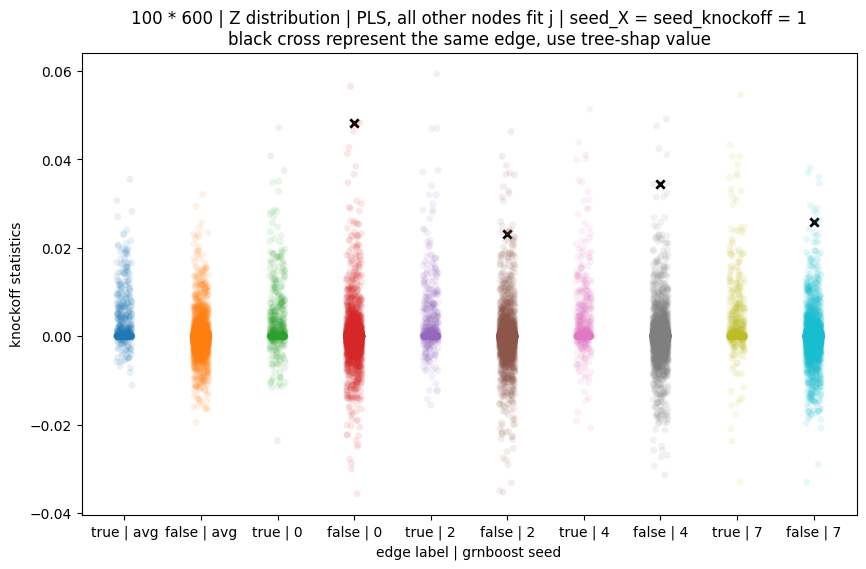

In [333]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
data = {
    'true | avg': Z[B_true].flatten(), 
    'false | avg': Z[~B_true].flatten(), 

    'true | 0': Z_full[0][B_true].flatten(), 
    'false | 0': Z_full[0][~B_true].flatten(), 

    'true | 2': Z_full[2][B_true].flatten(), 
    'false | 2': Z_full[2][~B_true].flatten(), 

    'true | 4': Z_full[4][B_true].flatten(), 
    'false | 4': Z_full[4][~B_true].flatten(), 

    'true | 7': Z_full[7][B_true].flatten(), 
    'false | 7': Z_full[7][~B_true].flatten(), 
}
sns.stripplot(data, alpha=0.1, ax=ax)

for i in range(len(Z_full)):
    print(f"{i}:", Z_full[i][61, 25])

data_highlight = {
    'false | 0': Z_full[0][61, 25],
    'false | 2': Z_full[2][61, 25],
    'false | 4': Z_full[4][61, 25],
    'false | 7': Z_full[7][61, 25],
}
sns.scatterplot(data_highlight, ax=ax, marker='x', color='black', linewidths=2)
ax.set_title("100 * 600 | Z distribution | PLS, all other nodes fit j | seed_X = seed_knockoff = 1\n"
             "black cross represent the same edge, use tree-shap value")
ax.set_xlabel("edge label | grnboost seed")
ax.set_ylabel("knockoff statistics")

In [328]:
np.where(Z_full[0] == Z_full[0].max())

(array([87]), array([48]))

In [ ]:
np.

In [187]:
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/'+ \
        'v100_600_normX_sym1_option_5_OLS_grnboost2/'+ \
        'W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z_OLS = (np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100]))

Text(0.5, 1.0, '100 * 600 | Z distribution | OLS, all other nodes fit j \n seed_X = seed_knockoff = 1, seed_model=0')

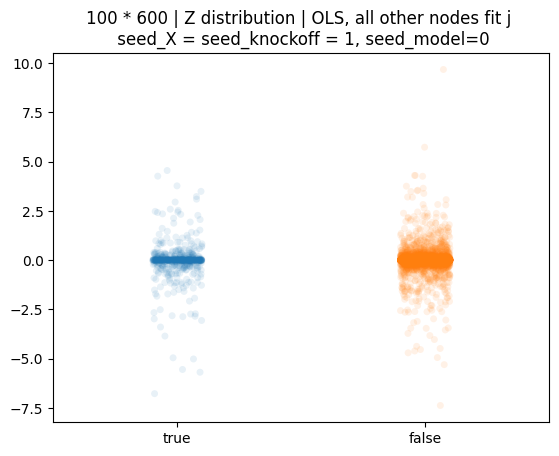

In [198]:
data = {
    'true': Z_OLS[B_true].flatten(),
    'false': Z_OLS[~B_true].flatten()
}
sns.stripplot(data, alpha=0.1)
plt.title("100 * 600 | Z distribution | OLS, all other nodes fit j \n seed_X = seed_knockoff = 1, seed_model=0")

In [175]:
fdr_log(Z_OLS, W_true, 1)

expected FDR 0.2
thresh 9.6717 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 7.3826 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 6.7822 | est fdr 3.0000 | true fdr 1.0000 | true power 0.0000
thresh 5.7271 | est fdr 1.5000 | true fdr 1.0000 | true power 0.0000
thresh 5.6946 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 5.5547 | est fdr 2.5000 | true fdr 1.0000 | true power 0.0000
thresh 5.3095 | est fdr 3.0000 | true fdr 1.0000 | true power 0.0000
thresh 5.0222 | est fdr 3.5000 | true fdr 1.0000 | true power 0.0000
thresh 4.9621 | est fdr 4.0000 | true fdr 1.0000 | true power 0.0000
thresh 4.9502 | est fdr 4.5000 | true fdr 1.0000 | true power 0.0000
thresh 4.7102 | est fdr 5.0000 | true fdr 1.0000 | true power 0.0000
thresh 4.6151 | est fdr 5.5000 | true fdr 1.0000 | true power 0.0000
thresh 4.5440 | est fdr 6.0000 | true fdr 1.0000 | true power 0.0000
thresh 4.5434 | est fdr 4.0000 | true fdr 0.6667 | true power 0.0017
thresh 4.4895 | e

# test if l1/l2 mitigates the collinearity problem with OLS/PLS knockoff

In [246]:
from tqdm import tqdm
import random

In [226]:
import sklearn
with open('/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX_sym1_option_5_OLS_grnboost2/knockoff/knockoff_1_1.pkl', 
          'rb') as f:
    X_tilde_OLS = pickle.load(f)
with open('/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/knockoff/knockoff_1_1.pkl', 
          'rb') as f:
    X_tilde_PLS = pickle.load(f)
X_OLS = np.concatenate([X, X_tilde_OLS], axis=1)
X_PLS = np.concatenate([X, X_tilde_PLS], axis=1)

In [320]:
def draw_temp(ax, X, model_name, title):
    res = np.zeros(
        (5, 200, 200)
    )
    for i in tqdm(range(100)):
        X_ = X.copy()
        X_[:, i] = 0.
        X_[:, i+100] = 0.
        if model_name == 'OLS':
            model = LinearRegression()
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha=1, l1_ratio=0.9)
        cv_model = sklearn.model_selection.cross_validate(
            model,
            X_,
            X[:, i],
            n_jobs=4,
            return_estimator=True)
        for j in range(5):
            res[j, :, i] = cv_model['estimator'][j].coef_
    Z = np.abs(res[:, :100, :]) - np.abs(res[:, 100:, :])
    
    data = {}
    data_highlight = {}
    for i in range(5):
        data[f'true | {i}']= Z[i, :, :100][B_true].flatten()
        data[f'false | {i}']= Z[i, :, :100][~B_true].flatten()
        data_highlight[f'false | {i}'] = Z[i][np.where(Z[0] == Z[0].max())][0]
    
    sns.stripplot(data, alpha=0.1, ax=ax)
    sns.scatterplot(data_highlight, ax=ax, marker='x', color='black', linewidths=2)

    ax.set_title(title)

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:04<00:11,  6.27it/s]/opt/anaconda3/envs/knockoff/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e+01, tolerance: 8.844e+00
  model = cd_fast.enet_coordinate_descent(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


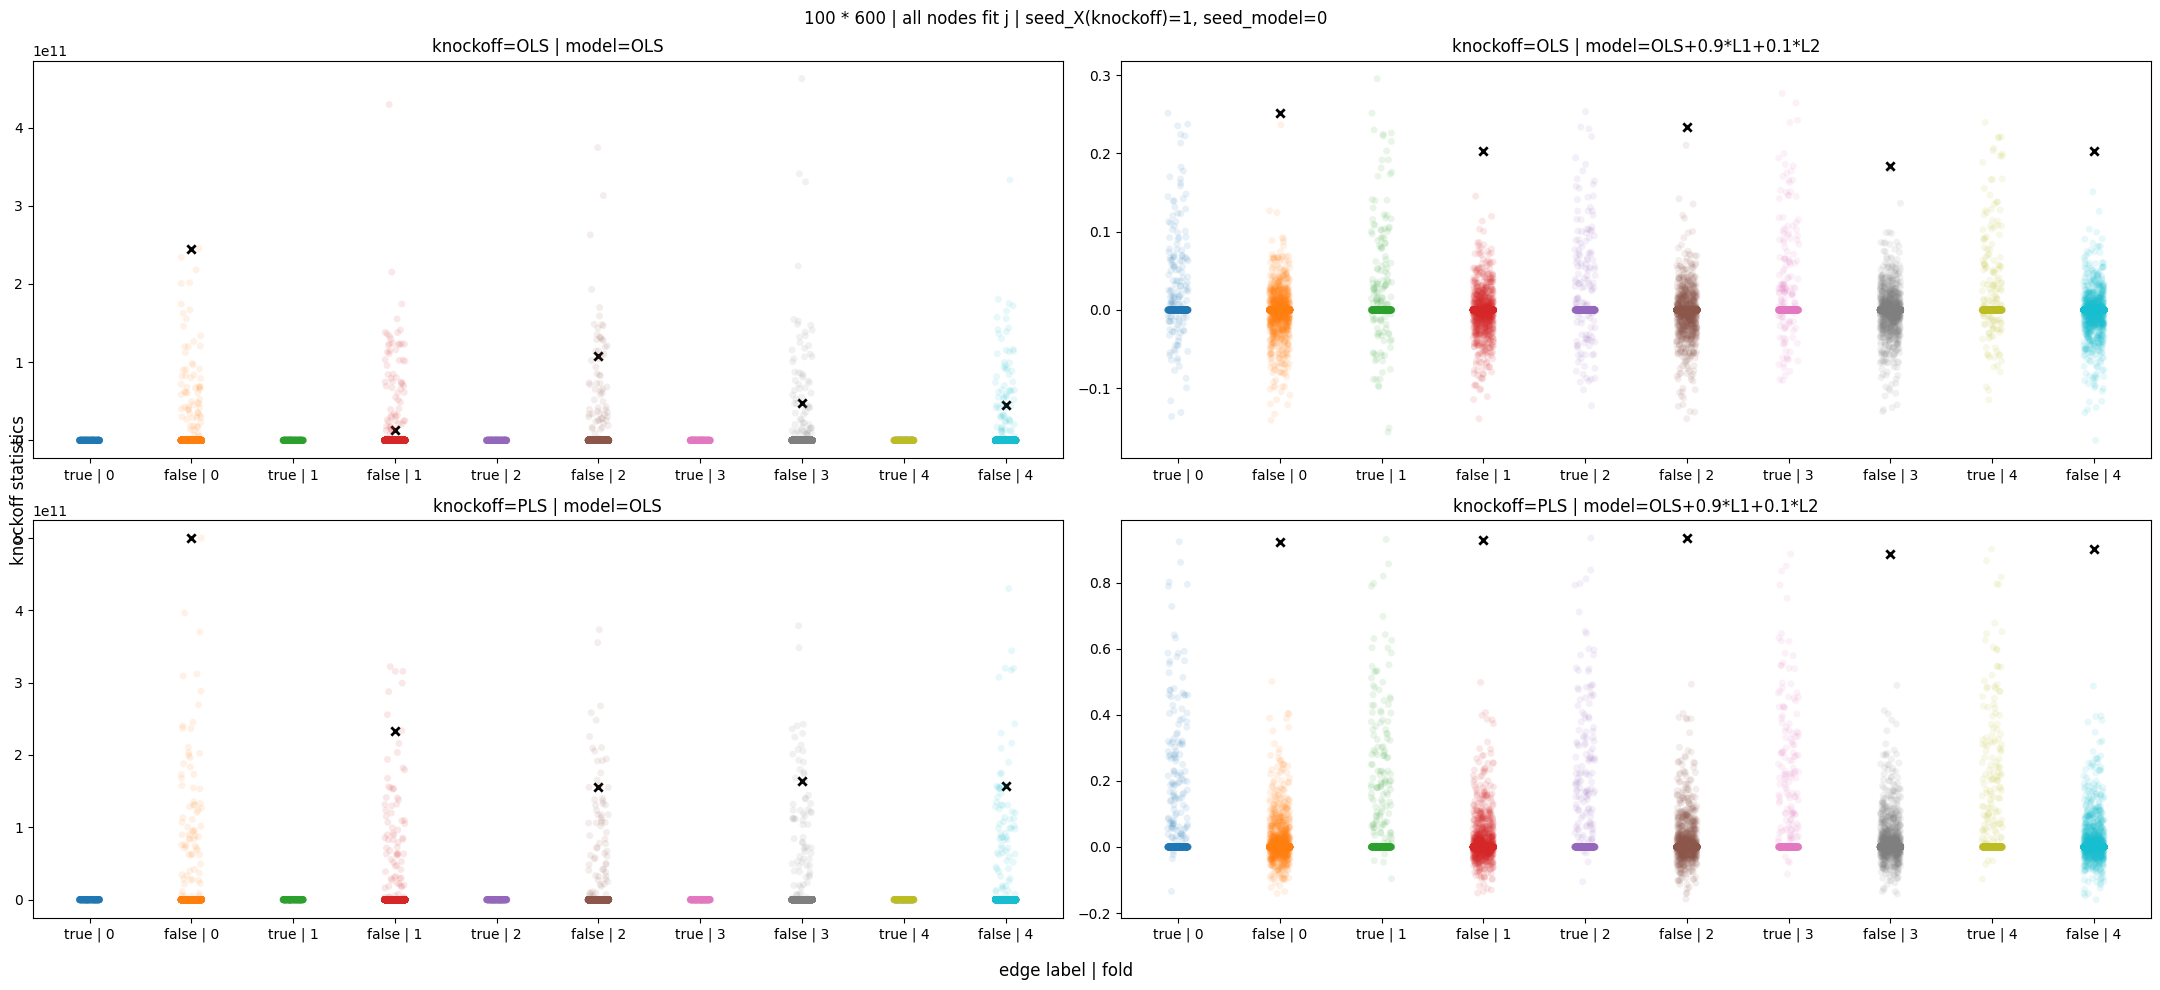

In [323]:
fig, axs = plt.subplots(2, 2, figsize=(22,10))
np.random.seed(0)
random.seed(0)
# knockoff=OLS, Model=OLS, 

draw_temp(axs[0][0], X_OLS, 'OLS', "knockoff=OLS | model=OLS")

# knockoff=OLS, Model=ElasticNet

draw_temp(axs[0][1], X_OLS, 'ElasticNet', "knockoff=OLS | model=OLS+0.9*L1+0.1*L2")

# knockoff=PLS, Model=OLS

draw_temp(axs[1][0], X_PLS, 'OLS', "knockoff=PLS | model=OLS")

# knockoff=PLS, Model=ElasticNet
draw_temp(axs[1][1], X_PLS, 'ElasticNet', "knockoff=PLS | model=OLS+0.9*L1+0.1*L2")

fig.suptitle("100 * 600 | all nodes fit j | seed_X(knockoff)=1, seed_model=0")
fig.supxlabel('edge label | fold')
fig.supylabel('knockoff statistics')
fig.tight_layout()

# test fitting residual of OLS, PLS and ElasticNet

In [342]:
import sklearn
with open('/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX_sym1_option_5_OLS_grnboost2/knockoff/knockoff_1_1.pkl', 
          'rb') as f:
    X_tilde_OLS = pickle.load(f)
with open('/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/knockoff/knockoff_1_1.pkl', 
          'rb') as f:
    X_tilde_PLS = pickle.load(f)

## OLS model

In [349]:
def get_resi(X, i, clf):
    X_ = X.copy()
    X_[:, i] = 0.
    clf.fit(X_, X[:, i])
    pred = clf.predict(X_)
    return sklearn.metrics.mean_squared_error(X[:, i], pred)

In [350]:
X_resi, OLS_resi, PLS_resi = [], [], []

for i in tqdm(range(100)):
    clf = LinearRegression()
    X_resi.append(get_resi(X, i, clf))

    clf = LinearRegression()
    OLS_resi.append(get_resi(X_tilde_OLS, i, clf))

    clf = LinearRegression()
    PLS_resi.append(get_resi(X_tilde_PLS, i, clf))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


<Axes: >

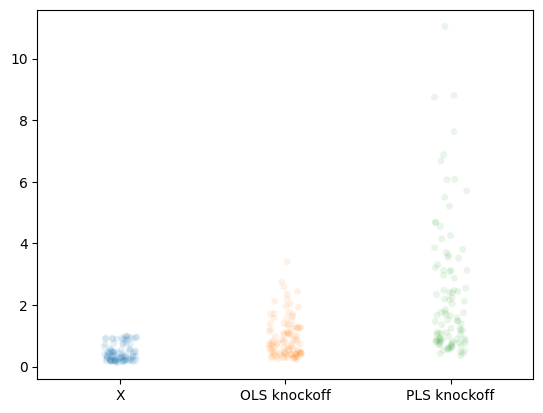

In [353]:
data_ols = {
    'X': X_resi,
    'OLS knockoff': OLS_resi,
    'PLS knockoff': PLS_resi
}
sns.stripplot(data_ols, alpha=0.1)

## ElasticNet model

In [354]:
X_resi, OLS_resi, PLS_resi = [], [], []

for i in tqdm(range(100)):
    clf = ElasticNet()
    X_resi.append(get_resi(X, i, clf))

    clf = ElasticNet()
    OLS_resi.append(get_resi(X_tilde_OLS, i, clf))

    clf = ElasticNet()
    PLS_resi.append(get_resi(X_tilde_PLS, i, clf))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.63it/s]


<Axes: >

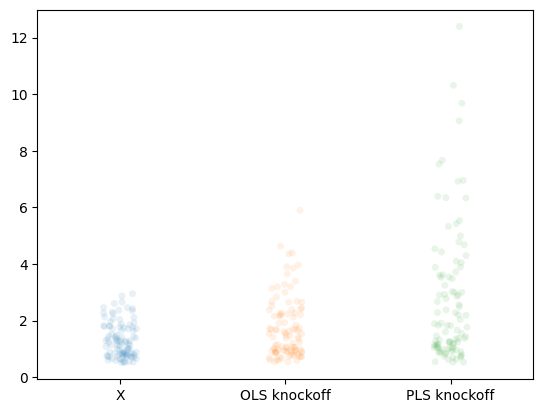

In [355]:
data_ela = {
    'X': X_resi,
    'OLS knockoff': OLS_resi,
    'PLS knockoff': PLS_resi
}
sns.stripplot(data_ela, alpha=0.1)

## Conclude visualization

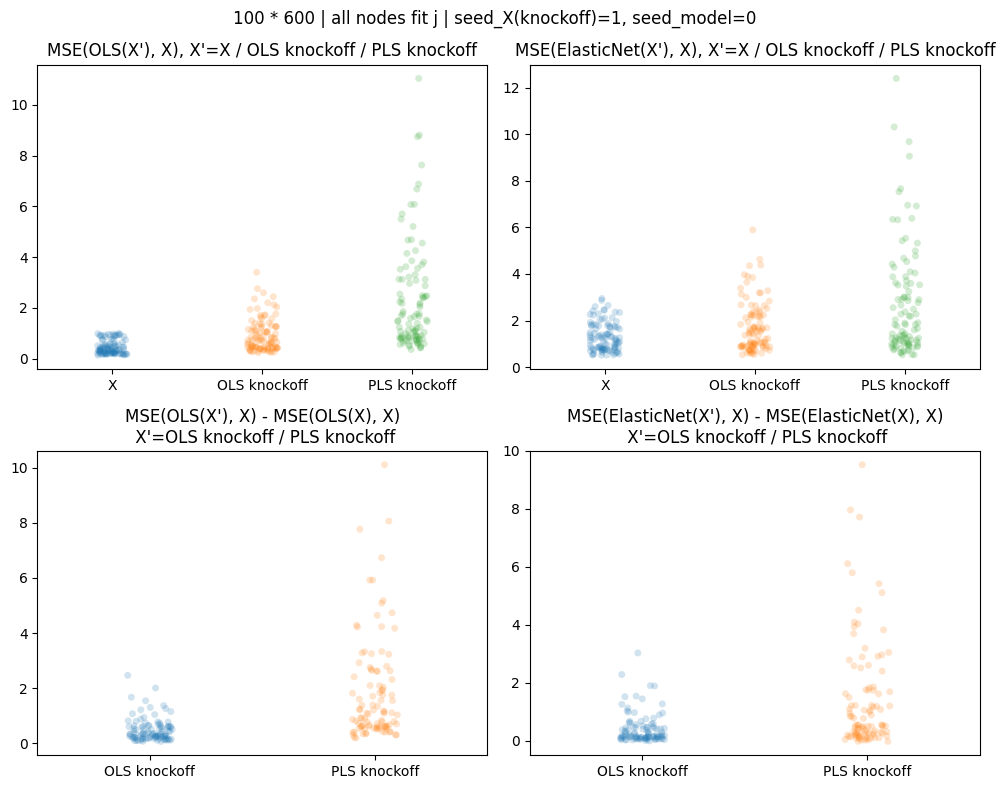

In [386]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

ax = axs[0][0]
sns.stripplot(data_ols, alpha=0.2, ax=ax)
ax.set_title("MSE(OLS(X'), X), X'=X / OLS knockoff / PLS knockoff")

ax = axs[0][1]
sns.stripplot(data_ela, alpha=0.2, ax=ax)
ax.set_title("MSE(ElasticNet(X'), X), X'=X / OLS knockoff / PLS knockoff")


ax = axs[1][0]
data_diff_ols = {
    'OLS knockoff': np.array(data_ols['OLS knockoff']) - np.array(data_ols['X']),
    'PLS knockoff': np.array(data_ols['PLS knockoff']) - np.array(data_ols['X'])
}
sns.stripplot(data_diff_ols, alpha=0.2, ax=ax)
ax.set_title("MSE(OLS(X'), X) - MSE(OLS(X), X)\n X'=OLS knockoff / PLS knockoff")

ax = axs[1][1]
data_diff_ela = {
    'OLS knockoff': np.array(data_ela['OLS knockoff']) - np.array(data_ela['X']),
    'PLS knockoff': np.array(data_ela['PLS knockoff']) - np.array(data_ela['X'])
}
sns.stripplot(data_diff_ela, alpha=0.2, ax=ax)
ax.set_title("MSE(ElasticNet(X'), X) - MSE(ElasticNet(X), X)\n X'=OLS knockoff / PLS knockoff")

fig.suptitle("100 * 600 | all nodes fit j | seed_X(knockoff)=1, seed_model=0")
fig.tight_layout()


# check OLS grnboost2

In [402]:
# baseline: OLS
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX_sym1_option_5_OLS_grnboost2/W/W_1_1_0.pkl'
with open(path, 'rb') as f:
    W_full = pickle.load(f)['W_est']
d = 100
Z = np.abs(W_full[:100, :100]) - np.abs(W_full[100:, :100])

<Axes: >

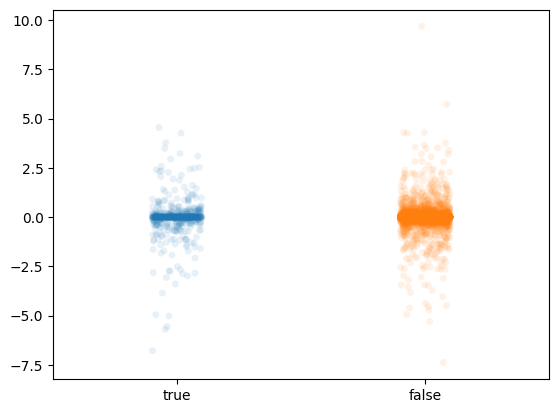

In [403]:
data = {
    'true': Z[B_true],
    'false': Z[~B_true]
}
sns.stripplot(data, alpha=0.1)

In [409]:
# baseline: OLS
path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v48/100_600/W_100_600_1_0_normX_sym1_grnboost2.pkl'
with open(path, 'rb') as f:
    W = pickle.load(f)

In [414]:
W_true

array([[ 0.        , -0.22427871,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.05199215,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.14851235,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.4578287 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

<Axes: >

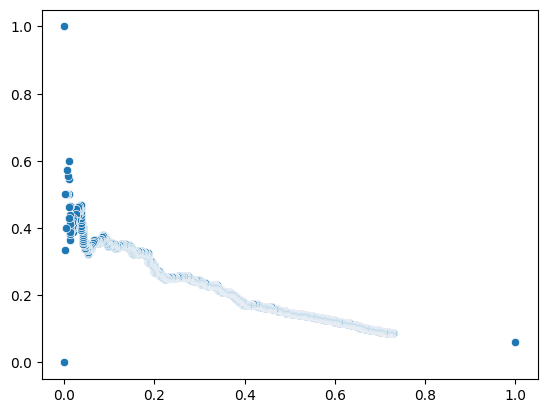

In [422]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(B_true.astype(int).flatten(), np.abs(W).flatten())
sns.scatterplot(x=recall, y=precision)

In [423]:
precision[:10]

array([0.06      , 0.08893401, 0.08895207, 0.08897014, 0.08898822,
       0.0890063 , 0.08902439, 0.08904249, 0.08906059, 0.08887533])

In [426]:
precision[:-1].max()

0.6